# An introduction to Linear Regression using linear models

## Agenda

- What is a **linear regression**, and how does it work?
- What are some **evaluation metrics** for regression problems?
- How to train a linear model with **multidimensional** inputs?
- What is a **basis function** and how to use to fit function with different shapes?
- How to apply **regularization** techniques?

- How do I choose **which features to include** in my model?
- How do I **train and interpret** a linear regression model in scikit-learn?


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Types of supervised learning

- **Classification:** Predict a categorical response
- **Regression:** Predict a continuous response

## Simple Linear Regression
Let's suppose to have data as pairs $D = \{(x^{(1)},t^{(1)}), ..., (x^{(N)},t^{(N)}) \}$ where
- $x$ is the input feature
- $t$ is the target output
Our aim is to fit a model, which is a function, with the following shape: $$ y(x)=w_0 +w_1x$$ where $w_0$ is called **bias** and $w_1$ is called **coefficient**, and they are both unknown.
Since the model is **fixed**, our assumption is that a linear model can be represented of the underline distribution in out data. 

To learn the parameters, we need an optimization algorithm and a loss function. Standard loss function is the **squared loss**.

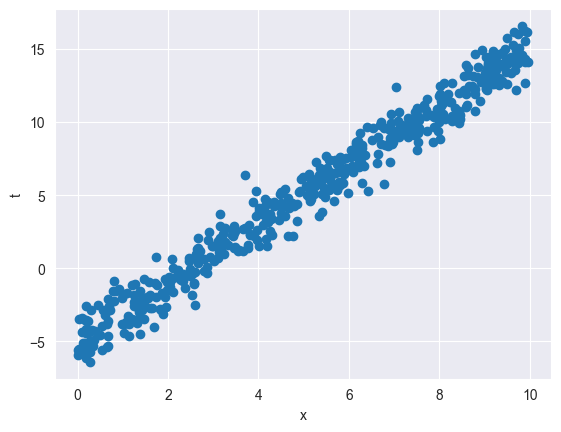

In [13]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(500)
t = 2 * X - 5 + rng.randn(500)
plt.scatter(X, t)
plt.xlabel('x')
plt.ylabel('t')
plt.show()

We split the data in training and test dataset, we will learn the parameters on the training and then we will evaluate on the test set.

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, shuffle=True) 

We can use Scikit-Learn's `LinearRegression` estimator to fit this data and construct the best-fit line.

In [15]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True, n_jobs=-1)

Now we can fit the model on the training data and learn the parameters.

In [17]:
model.fit(X_train[:, np.newaxis], t_train)

LinearRegression(n_jobs=-1)

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore.
Here the relevant parameters are `coef_` and `intercept_`:

In [20]:
print("Model slope (w1):    ", model.coef_[0])
print("Model intercept (w0):", model.intercept_)

Model slope (w1):     2.018110321354475
Model intercept (w0): -5.021303913331174


We can check the shape of the function that we have fitted.

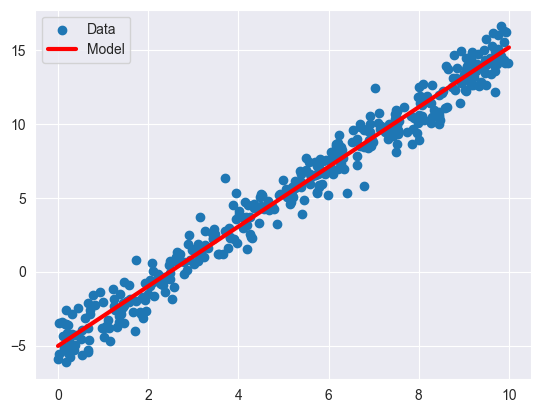

In [25]:
X_train_fit = np.linspace(0, 10, 1000)
t_train_fit = model.predict(X_train_fit[:, np.newaxis])
plt.scatter(X_train, t_train)
plt.plot(X_train_fit, t_train_fit, color='red', linewidth=3);
plt.legend(['Data', 'Model'], loc='best')

### How can evaluate a regression model? 
Evaluation metrics for classification problems, such as **accuracy**, are not useful for regression problems. Instead, we need evaluation metrics designed for comparing continuous values.

Let's create some example numeric predictions, and calculate **some common evaluation metrics** for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

**Coefficient of determination** (R$^2$) The coefficient of determination measures how well a statistical model predicts an outcome: 

$$R^2 = 1- \frac{\sum^{m}_{i=1}({y_{i}- \widehat{y_{i}})^2}}{\sum^{m}_{i=1}{(y_{i}- \bar{y})^2}}$$


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
t_test_fit = model.predict(X_test[:, np.newaxis])
print(f'Mean absolute error on the test set: {mean_absolute_error(t_test, t_test_fit)}')
print(f'Mean squared error on the test set: {mean_squared_error(t_test, t_test_fit)}')
print(f'Root mean squared error on the test set:'
      f' {root_mean_squared_error(t_test, t_test_fit)}')
print(f'R2 score on the test set: {r2_score(t_test, t_test_fit)}')

Mean absolute error on the test set: 0.8572453842344626
Mean squared error on the test set: 1.1529703866148504
Root mean squared error on the test set: 1.0737645862175054
R2 score on the test set: 0.9622113856573223
